In [1]:
from google.colab import files
import io
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
import scipy.stats as stats
from matplotlib.lines import Line2D
from matplotlib import ticker
import matplotlib.gridspec as gridspec

In [2]:
# Mounting my google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Let's first (re)compute all the empirical divergence correlations:

In [3]:
# Function to compute the confidence interval on spearman rho
def spearman_ci(x, y, ci=95, n_boots=10000, seed=22):
  x = np.asarray(x)
  y = np.asarray(y)

  # (n_boots, n_observations) paired arrays
  rng = np.random.default_rng(seed) # For reproducible bootstrapping
  rand_ixs = rng.integers(0, x.shape[0], size=(n_boots, x.shape[0]))
  x_boots = x[rand_ixs]
  y_boots = y[rand_ixs]

  # Spearman correlations
  corrs = []

  for row in range(x_boots.shape[0]):
    rho = stats.spearmanr(x_boots[row, :], y_boots[row, :])
    corrs.append(rho[0])

  # Quantiles of correlations coefficients and confidence interval
  corrs = np.asarray(corrs)

  ci_low = np.percentile(corrs, (100 - ci) / 2)
  ci_high = np.percentile(corrs, (ci + 100) / 2)

  return ci_low, ci_high, corrs

In [4]:
# Empirical divergence data is imported
couples_divergence = pd.read_csv('/content/drive/My Drive/Redaction_SA/'
                                 'Final_figures/Data_sim_ready/'
                                 'couples_divergence.csv')

# Only WGD-derived pairs are kept
couples_divergence = couples_divergence[couples_divergence['Duplication'] == 'WGD'].reset_index(drop=True)

In [5]:
# Confidence interval on the empirical correlation of divergence
rho_emp = spearman_ci(couples_divergence['bm_fold_original'],
                      couples_divergence['bp_fold_original'])
spearman_ci_div = (rho_emp[0], rho_emp[1])
dist_boot_div = rho_emp[2]

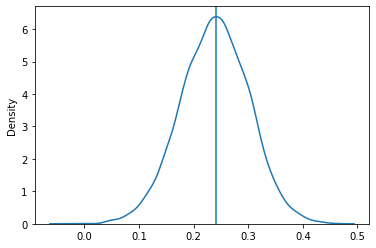

In [6]:
# Quick validation that bootstrapping is valid:
center_div = stats.spearmanr(couples_divergence['bm_fold_original'],
                         couples_divergence['bp_fold_original'])[0]

sns.kdeplot(dist_boot_div)
plt.axvline(x=center_div)

The 95% confidence interval is also computed for the signed divergence correlation:

In this case, a duplicated dataset is used, so that logfold changes are computed in the two possible orientations for each paralog pair

In [7]:
couples_divergence['bm_fold_signed_1'] = np.log2((10**couples_divergence['bm_P1']) / (10**couples_divergence['bm_P2']))
couples_divergence['bp_fold_signed_1'] = np.log2((10**couples_divergence['bp_P1']) / (10**couples_divergence['bp_P2']))
couples_divergence['bm_fold_signed_2'] = np.log2((10**couples_divergence['bm_P2']) / (10**couples_divergence['bm_P1']))
couples_divergence['bp_fold_signed_2'] = np.log2((10**couples_divergence['bp_P2']) / (10**couples_divergence['bp_P1']))

In [8]:
logfold_dupli_1 = couples_divergence[['Duplication', 'ORF_P1', 'ORF_P2',
                                    'bm_fold_signed_1', 'bp_fold_signed_1']].copy()

logfold_dupli_1.columns = ['Duplication', 'ORF_P1', 'ORF_P2',
                          'bm_fold_signed', 'bp_fold_signed']


logfold_dupli_2 = couples_divergence[['Duplication', 'ORF_P1', 'ORF_P2',
                                    'bm_fold_signed_2', 'bp_fold_signed_2']].copy()

logfold_dupli_2.columns = ['Duplication', 'ORF_P1', 'ORF_P2',
                          'bm_fold_signed', 'bp_fold_signed']

logfold_dupli = pd.concat([logfold_dupli_1, logfold_dupli_2])

In [9]:
# Confidence interval on the empirical correlation of divergence
rho_emp = spearman_ci(logfold_dupli['bm_fold_signed'],
                      logfold_dupli['bp_fold_signed'])
spearman_ci_sign = (rho_emp[0], rho_emp[1])
dist_boot_sign = rho_emp[2]

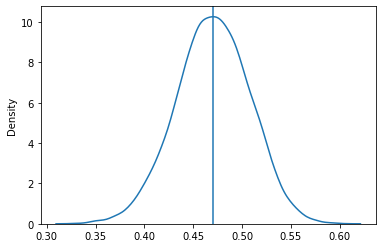

In [10]:
# Quick validation that bootstrapping is valid:
center_sign = stats.spearmanr(logfold_dupli['bm_fold_signed'],
                              logfold_dupli['bp_fold_signed'])[0]

sns.kdeplot(dist_boot_sign)
plt.axvline(x=center_sign)

Finally, the same is done for the correlation between the divergence ratio and the magnitude of protein abundance divergence:

In [11]:
couples_divergence['div_ratio'] = couples_divergence['bm_fold_original'] - couples_divergence['bp_fold_original']

In [12]:
# Confidence interval on the empirical correlation of divergence
rho_emp = spearman_ci(couples_divergence['pEst_fold_original'],
                      couples_divergence['div_ratio'])
spearman_ci_ratio = (rho_emp[0], rho_emp[1])
dist_boot_ratio = rho_emp[2]

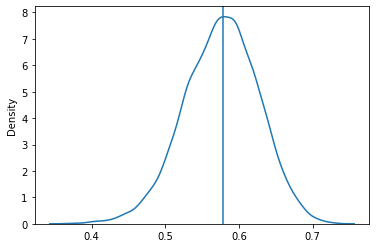

In [13]:
# Quick validation that bootstrapping is valid:
center_ratio = stats.spearmanr(couples_divergence['pEst_fold_original'],
                         couples_divergence['div_ratio'])[0]

sns.kdeplot(dist_boot_ratio)
plt.axvline(x=center_ratio)

In [14]:
# Simulation data (divergence correlations, KS statistics and Mood's p-values),
# already computed for all runs and combined in a single dataframe, are
# imported

corr_alpha = pd.read_csv('/content/drive/My Drive/Redaction_SA/'
                         'Final_figures/Mut_alpha_WGD/Corr_alpha.csv')

corr_sign = pd.read_csv('/content/drive/My Drive/Redaction_SA/'
                         'Final_figures/Mut_alpha_WGD/Corr_sign.csv')

corr_ratio_alpha = pd.read_csv('/content/drive/My Drive/Redaction_SA/'
                         'Final_figures/Mut_alpha_WGD/Corr_ratio_alpha.csv')

KS_alpha = pd.read_csv('/content/drive/My Drive/Redaction_SA/'
                       'Final_figures/Mut_alpha_WGD/KS_alpha.csv')
KS_alpha = KS_alpha[KS_alpha['Comparison'] == 
                            'WGD'].reset_index(drop=True)

Moods_alpha = pd.read_csv('/content/drive/My Drive/Redaction_SA/'
                          'Final_figures/Mut_alpha_WGD/Mood_results.csv')

In [15]:
# Also for simulations with correlated mutational effects

corr_bivariate = pd.read_csv('/content/drive/My Drive/Redaction_SA/'
                             'Final_figures/Mut_bivariate_WGD/Corr_bivariate.csv')

corr_sign_bi = pd.read_csv('/content/drive/My Drive/Redaction_SA/'
                           'Final_figures/Mut_bivariate_WGD/Corr_sign.csv')

corr_ratio_bi = pd.read_csv('/content/drive/My Drive/Redaction_SA/'
                            'Final_figures/Mut_bivariate_WGD/Corr_ratio_bivariate.csv')

KS_bivariate = pd.read_csv('/content/drive/My Drive/Redaction_SA/'
                           'Final_figures/Mut_bivariate_WGD/KS_correlation.csv')
KS_bivariate = KS_bivariate[KS_bivariate['Comparison'] == 
                            'WGD'].reset_index(drop=True)

Moods_bivariate = pd.read_csv('/content/drive/My Drive/Redaction_SA/'
                              'Final_figures/Mut_bivariate_WGD/Mood_results.csv')

## 1) This data is first processed for the simulations asymmetrical distributions of mutational effects:

In [16]:
# For Moods p-value and correlation coefficients, separate dataframes are
# made for each iteration

# Divergence correlations
corr_iter1a = corr_alpha[corr_alpha['Iter'] == 'iter1']
corr_iter2a = corr_alpha[corr_alpha['Iter'] == 'iter2']
corr_iter3a = corr_alpha[corr_alpha['Iter'] == 'iter3']

# Signed divergence correlations

corr_sign_iter1a = corr_sign[corr_sign['Iter'] == 'iter1']
corr_sign_iter2a = corr_sign[corr_sign['Iter'] == 'iter2']
corr_sign_iter3a = corr_sign[corr_sign['Iter'] == 'iter3']

# Ratio correlations
corr_ratio_iter1 = corr_ratio_alpha[corr_ratio_alpha['Iter'] == 'iter1']
corr_ratio_iter2 = corr_ratio_alpha[corr_ratio_alpha['Iter'] == 'iter2']
corr_ratio_iter3 = corr_ratio_alpha[corr_ratio_alpha['Iter'] == 'iter3']

Moods_iter1a = Moods_alpha[Moods_alpha['Iter'] == 'iter1']
Moods_iter2a = Moods_alpha[Moods_alpha['Iter'] == 'iter2']
Moods_iter3a = Moods_alpha[Moods_alpha['Iter'] == 'iter3']

In [17]:
# Corresponding matrices are made

# Divergence correlations
rho_min_1a = corr_iter1a[corr_iter1a['Model'] == 'Minimal'].pivot(index='Mut_alpha',
            columns='Run', values='spearman')
rho_min_2a = corr_iter2a[corr_iter2a['Model'] == 'Minimal'].pivot(index='Mut_alpha',
            columns='Run', values='spearman')
rho_min_3a = corr_iter3a[corr_iter3a['Model'] == 'Minimal'].pivot(index='Mut_alpha',
            columns='Run', values='spearman')

# Signed divergence correlations
rho_sign_min_1a = corr_sign_iter1a[corr_sign_iter1a['Model'] == 'Minimal'].pivot(index='Mut_alpha', columns='Run', values='spearman')

rho_sign_min_2a = corr_sign_iter2a[corr_sign_iter2a['Model'] == 'Minimal'].pivot(index='Mut_alpha', columns='Run', values='spearman')

rho_sign_min_3a = corr_sign_iter3a[corr_sign_iter3a['Model'] == 'Minimal'].pivot(index='Mut_alpha', columns='Run', values='spearman')

# Ratio correlations
rho_ratio_min_1a = corr_ratio_iter1[corr_ratio_iter1['Model'] == 'Minimal'].pivot(index='Mut_alpha', columns='Run', values='spearman')

rho_ratio_min_2a = corr_ratio_iter2[corr_ratio_iter2['Model'] == 'Minimal'].pivot(index='Mut_alpha', columns='Run', values='spearman')

rho_ratio_min_3a = corr_ratio_iter3[corr_ratio_iter3['Model'] == 'Minimal'].pivot(index='Mut_alpha', columns='Run', values='spearman')

# Moods iter1 
Moods_1a_bm = Moods_iter1a[(Moods_iter1a['Parameter'] == 'Transcription rate') &
                         (Moods_iter1a['Model'] == 'Minimal')].pivot(index='Mut_alpha', 
                         columns='Run', values='p-value')

Moods_1a_bp = Moods_iter1a[(Moods_iter1a['Parameter'] == 'Translation rate') &
                         (Moods_iter1a['Model'] == 'Minimal')].pivot(index='Mut_alpha', 
                         columns='Run', values='p-value')

Moods_1a_p = Moods_iter1a[(Moods_iter1a['Parameter'] == 'Protein abundance') &
                        (Moods_iter1a['Model'] == 'Minimal')].pivot(index='Mut_alpha', 
                        columns='Run', values='p-value')

Moods_1a_ratio = Moods_iter1a[(Moods_iter1a['Parameter'] == 'Divergence ratio') &
                         (Moods_iter1a['Model'] == 'Minimal')].pivot(index='Mut_alpha', 
                         columns='Run', values='p-value')

# Moods iter2 
Moods_2a_bm = Moods_iter2a[(Moods_iter2a['Parameter'] == 'Transcription rate') &
                         (Moods_iter2a['Model'] == 'Minimal')].pivot(index='Mut_alpha', 
                         columns='Run', values='p-value')

Moods_2a_bp = Moods_iter2a[(Moods_iter2a['Parameter'] == 'Translation rate') &
                         (Moods_iter2a['Model'] == 'Minimal')].pivot(index='Mut_alpha', 
                         columns='Run', values='p-value')

Moods_2a_p = Moods_iter2a[(Moods_iter2a['Parameter'] == 'Protein abundance') &
                        (Moods_iter2a['Model'] == 'Minimal')].pivot(index='Mut_alpha', 
                        columns='Run', values='p-value')

Moods_2a_ratio = Moods_iter2a[(Moods_iter2a['Parameter'] == 'Divergence ratio') &
                         (Moods_iter2a['Model'] == 'Minimal')].pivot(index='Mut_alpha', 
                         columns='Run', values='p-value')

# Moods iter3
Moods_3a_bm = Moods_iter3a[(Moods_iter3a['Parameter'] == 'Transcription rate') &
                         (Moods_iter3a['Model'] == 'Minimal')].pivot(index='Mut_alpha', 
                         columns='Run', values='p-value')

Moods_3a_bp = Moods_iter3a[(Moods_iter3a['Parameter'] == 'Translation rate') &
                         (Moods_iter3a['Model'] == 'Minimal')].pivot(index='Mut_alpha', 
                         columns='Run', values='p-value')

Moods_3a_p = Moods_iter3a[(Moods_iter3a['Parameter'] == 'Protein abundance') &
                        (Moods_iter3a['Model'] == 'Minimal')].pivot(index='Mut_alpha', 
                        columns='Run', values='p-value')

Moods_3a_ratio = Moods_iter3a[(Moods_iter3a['Parameter'] == 'Divergence ratio') &
                         (Moods_iter3a['Model'] == 'Minimal')].pivot(index='Mut_alpha', 
                         columns='Run', values='p-value')

In [18]:
# These matrices are reindexed and reordered
dfs = [rho_min_1a, rho_min_2a, rho_min_3a, rho_sign_min_1a, rho_sign_min_2a, 
       rho_sign_min_3a, rho_ratio_min_1a, rho_ratio_min_2a, rho_ratio_min_3a, 
       Moods_1a_bm, Moods_1a_bp, Moods_1a_p, Moods_1a_ratio, Moods_2a_bm, 
       Moods_2a_bp, Moods_2a_p, Moods_2a_ratio, Moods_3a_bm, Moods_3a_bp, 
       Moods_3a_p, Moods_3a_ratio]

for df in dfs:
    df.columns = ['1/2', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9']

# For reordering the matrices
columns = ['1/2', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

# Reordering each
rho_min_1a = rho_min_1a.reindex(labels=columns, axis='columns')
rho_min_2a = rho_min_2a.reindex(labels=columns, axis='columns')
rho_min_3a = rho_min_3a.reindex(labels=columns, axis='columns')

rho_sign_min_1a = rho_sign_min_1a.reindex(labels=columns, axis='columns')
rho_sign_min_2a = rho_sign_min_2a.reindex(labels=columns, axis='columns')
rho_sign_min_3a = rho_sign_min_3a.reindex(labels=columns, axis='columns')

rho_ratio_min_1a = rho_ratio_min_1a.reindex(labels=columns, axis='columns')
rho_ratio_min_2a = rho_ratio_min_2a.reindex(labels=columns, axis='columns')
rho_ratio_min_3a = rho_ratio_min_3a.reindex(labels=columns, axis='columns')

Moods_1a_bm = Moods_1a_bm.reindex(labels=columns, axis='columns')
Moods_1a_bp = Moods_1a_bp.reindex(labels=columns, axis='columns')
Moods_1a_p = Moods_1a_p.reindex(labels=columns, axis='columns')
Moods_1a_ratio = Moods_1a_ratio.reindex(labels=columns, axis='columns')

Moods_2a_bm = Moods_2a_bm.reindex(labels=columns, axis='columns')
Moods_2a_bp = Moods_2a_bp.reindex(labels=columns, axis='columns')
Moods_2a_p = Moods_2a_p.reindex(labels=columns, axis='columns')
Moods_2a_ratio = Moods_2a_ratio.reindex(labels=columns, axis='columns')

Moods_3a_bm = Moods_3a_bm.reindex(labels=columns, axis='columns')
Moods_3a_bp = Moods_3a_bp.reindex(labels=columns, axis='columns')
Moods_3a_p = Moods_3a_p.reindex(labels=columns, axis='columns')
Moods_3a_ratio = Moods_3a_ratio.reindex(labels=columns, axis='columns')

Matrices of annotations (for the heatmaps) are made:

First, if the 4 Mood's p-values are >0.05 for at least one replicate

In [19]:
Moods_1a_bm = np.where(Moods_1a_bm > 0.05, 1, 0)
Moods_1a_bp = np.where(Moods_1a_bp > 0.05, 1, 0)
Moods_1a_p = np.where(Moods_1a_p > 0.05, 1, 0)
Moods_1a_ratio = np.where(Moods_1a_ratio > 0.05, 1, 0)

Moods_iter1a = Moods_1a_bm + Moods_1a_bp + Moods_1a_p + Moods_1a_ratio
Moods_iter1a = np.where(Moods_iter1a == 4, 1, 0)

Moods_2a_bm = np.where(Moods_2a_bm > 0.05, 1, 0)
Moods_2a_bp = np.where(Moods_2a_bp > 0.05, 1, 0)
Moods_2a_p = np.where(Moods_2a_p > 0.05, 1, 0)
Moods_2a_ratio = np.where(Moods_2a_ratio > 0.05, 1, 0)

Moods_iter2a = Moods_2a_bm + Moods_2a_bp + Moods_2a_p + Moods_2a_ratio
Moods_iter2a = np.where(Moods_iter2a == 4, 1, 0)

Moods_3a_bm = np.where(Moods_3a_bm > 0.05, 1, 0)
Moods_3a_bp = np.where(Moods_3a_bp > 0.05, 1, 0)
Moods_3a_p = np.where(Moods_3a_p > 0.05, 1, 0)
Moods_3a_ratio = np.where(Moods_3a_ratio > 0.05, 1, 0)

Moods_iter3a = Moods_3a_bm + Moods_3a_bp + Moods_3a_p + Moods_3a_ratio
Moods_iter3a = np.where(Moods_iter3a == 4, 1, 0)

In [20]:
Moods_any_a = Moods_iter1a + Moods_iter2a + Moods_iter3a
Moods_any_a = np.where(Moods_any_a > 0, 1, 0)

Second, if the simulated correlation is within the empirical CI for at least one replicate (done separately for each type of correlation):

In [21]:
# Divergence correlation
rho_min_1a = np.where((rho_min_1a >= spearman_ci_div[0]) & (rho_min_1a <= spearman_ci_div[1]), 1, 0)
rho_min_2a = np.where((rho_min_2a >= spearman_ci_div[0]) & (rho_min_2a <= spearman_ci_div[1]), 1, 0)
rho_min_3a = np.where((rho_min_3a >= spearman_ci_div[0]) & (rho_min_3a <= spearman_ci_div[1]), 1, 0)

rho_equal_a = rho_min_1a + rho_min_2a + rho_min_3a
rho_equal_a = np.where(rho_equal_a > 0, 1, 0)

# Signed divergence correlation
rho_sign_min_1a = np.where((rho_sign_min_1a >= spearman_ci_sign[0]) & (rho_sign_min_1a <= spearman_ci_sign[1]), 1, 0)
rho_sign_min_2a = np.where((rho_sign_min_2a >= spearman_ci_sign[0]) & (rho_sign_min_2a <= spearman_ci_sign[1]), 1, 0)
rho_sign_min_3a = np.where((rho_sign_min_3a >= spearman_ci_sign[0]) & (rho_sign_min_3a <= spearman_ci_sign[1]), 1, 0)

rho_sign_equal_a = rho_sign_min_1a + rho_sign_min_2a + rho_sign_min_3a
rho_sign_equal_a = np.where(rho_sign_equal_a > 0, 1, 0)

# Divergence ratio correlation
rho_ratio_min_1a = np.where((rho_ratio_min_1a >= spearman_ci_ratio[0]) & (rho_ratio_min_1a <= spearman_ci_ratio[1]), 1, 0)
rho_ratio_min_2a = np.where((rho_ratio_min_2a >= spearman_ci_ratio[0]) & (rho_ratio_min_2a <= spearman_ci_ratio[1]), 1, 0)
rho_ratio_min_3a = np.where((rho_ratio_min_3a >= spearman_ci_ratio[0]) & (rho_ratio_min_3a <= spearman_ci_ratio[1]), 1, 0)

rho_ratio_equal_a = rho_ratio_min_1a + rho_ratio_min_2a + rho_ratio_min_3a
rho_ratio_equal_a = np.where(rho_ratio_equal_a > 0, 1, 0)

Finally, one last matrix of annotations is made, this time to identify parameter combinations where all four conditions are met

In [22]:
annot_all = Moods_any_a * rho_equal_a * rho_sign_equal_a * rho_ratio_equal_a

# Numbers are replaced by the appropriate character within each matrix
Moods_any_a = Moods_any_a - annot_all
Moods_any_a = np.where(Moods_any_a == 1, '*', '')
annot_all = np.where(annot_all == 1, '*', '')

rho_equal_a = np.where(rho_equal_a == 1, '≈', '')
rho_sign_equal_a = np.where(rho_sign_equal_a == 1, '≈', '')
rho_ratio_equal_a = np.where(rho_ratio_equal_a == 1, '≈', '')

The matrices that will be used to generate the heatmaps (both data and annotation) are reordered

In [23]:
# First, matrix of mean KS stats
KS_means_a = KS_alpha.groupby(by=['Model', 'Comparison', 'Run',
                                  'Mut_alpha'], as_index=False).mean()

KS_means_a = KS_means_a[KS_means_a['Model'] == 'Minimal'].pivot(index='Mut_alpha', 
                         columns='Run', values='KS stats')

In [24]:
# Second, matrices of spearman coefficients

# Divergence
corr_spearman_a = corr_alpha[corr_alpha['Model'] == 'Minimal']
corr_spearman_a = corr_spearman_a.groupby(by=['Run', 'Mut_alpha', 'Model'],
                                      as_index=False).mean()

rho_min_all_a = corr_spearman_a.pivot(index='Mut_alpha', 
                         columns='Run', values='spearman')

# Signed
corr_sign_a = corr_sign[corr_sign['Model'] == 'Minimal']
corr_sign_a = corr_sign_a.groupby(by=['Run', 'Mut_alpha', 'Model'],
                                      as_index=False).mean()

rho_sign_all_a = corr_sign_a.pivot(index='Mut_alpha', 
                                   columns='Run', values='spearman')

# Ratio
corr_ratio_a = corr_ratio_alpha[corr_ratio_alpha['Model'] == 'Minimal']
corr_ratio_a = corr_ratio_a.groupby(by=['Run', 'Mut_alpha', 'Model'],
                                    as_index=False).mean()

rho_ratio_all_a = corr_ratio_a.pivot(index='Mut_alpha', 
                                     columns='Run', values='spearman')

In [25]:
# Column names are modified and each matrix is reordered
dfs = [KS_means_a, rho_min_all_a, rho_sign_all_a, rho_ratio_all_a]
for df in dfs:
    df.columns = ['1/2', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9']
    df.index = ['-0.350', '-0.250', '-0.175', '-0.150', '-0.125', '-0.100',
                '-0.075', '-0.050', '-0.010', '0.000']

rho_min_all_a = rho_min_all_a.reindex(labels=columns, axis='columns')
KS_means_a = KS_means_a.reindex(labels=columns, axis='columns')
KS_means_a = KS_means_a * -1
rho_sign_all_a = rho_sign_all_a.reindex(labels=columns, axis='columns')
rho_ratio_all_a = rho_ratio_all_a.reindex(labels=columns, axis='columns')

## 2) The same processing is repeated for the simulations with correlated mutational effects

In [26]:
# For Moods p-value and correlation coefficients, separate dataframes are
# made for each iteration

# Divergence correlations
corr_iter1b = corr_bivariate[corr_bivariate['Iter'] == 'iter1']
corr_iter2b = corr_bivariate[corr_bivariate['Iter'] == 'iter2']
corr_iter3b = corr_bivariate[corr_bivariate['Iter'] == 'iter3']

# Signed divergence correlations

corr_sign_iter1b = corr_sign_bi[corr_sign_bi['Iter'] == 'iter1']
corr_sign_iter2b = corr_sign_bi[corr_sign_bi['Iter'] == 'iter2']
corr_sign_iter3b = corr_sign_bi[corr_sign_bi['Iter'] == 'iter3']

# Ratio correlations
corr_ratio_iter1b = corr_ratio_bi[corr_ratio_bi['Iter'] == 'iter1']
corr_ratio_iter2b = corr_ratio_bi[corr_ratio_bi['Iter'] == 'iter2']
corr_ratio_iter3b = corr_ratio_bi[corr_ratio_bi['Iter'] == 'iter3']

Moods_iter1b = Moods_bivariate[Moods_bivariate['Iter'] == 'iter1']
Moods_iter2b = Moods_bivariate[Moods_bivariate['Iter'] == 'iter2']
Moods_iter3b = Moods_bivariate[Moods_bivariate['Iter'] == 'iter3']

In [27]:
# Corresponding matrices are made

# Divergence correlations
rho_min_1b = corr_iter1b[corr_iter1b['Model'] == 'Minimal'].pivot(index='Mut_corr',
            columns='Run', values='spearman')
rho_min_2b = corr_iter2b[corr_iter2b['Model'] == 'Minimal'].pivot(index='Mut_corr',
            columns='Run', values='spearman')
rho_min_3b = corr_iter3b[corr_iter3b['Model'] == 'Minimal'].pivot(index='Mut_corr',
            columns='Run', values='spearman')

# Signed divergence correlations
rho_sign_min_1b = corr_sign_iter1b[corr_sign_iter1b['Model'] == 'Minimal'].pivot(index='Mut_corr', columns='Run', values='spearman')

rho_sign_min_2b = corr_sign_iter2b[corr_sign_iter2b['Model'] == 'Minimal'].pivot(index='Mut_corr', columns='Run', values='spearman')

rho_sign_min_3b = corr_sign_iter3b[corr_sign_iter3b['Model'] == 'Minimal'].pivot(index='Mut_corr', columns='Run', values='spearman')

# Ratio correlations
rho_ratio_min_1b = corr_ratio_iter1b[corr_ratio_iter1b['Model'] == 'Minimal'].pivot(index='Mut_corr', columns='Run', values='spearman')

rho_ratio_min_2b = corr_ratio_iter2b[corr_ratio_iter2b['Model'] == 'Minimal'].pivot(index='Mut_corr', columns='Run', values='spearman')

rho_ratio_min_3b = corr_ratio_iter3b[corr_ratio_iter3b['Model'] == 'Minimal'].pivot(index='Mut_corr', columns='Run', values='spearman')

# Moods iter1 
Moods_1b_bm = Moods_iter1b[(Moods_iter1b['Parameter'] == 'Transcription rate') &
                         (Moods_iter1b['Model'] == 'Minimal')].pivot(index='Mut_corr', 
                         columns='Run', values='p-value')

Moods_1b_bp = Moods_iter1b[(Moods_iter1b['Parameter'] == 'Translation rate') &
                         (Moods_iter1b['Model'] == 'Minimal')].pivot(index='Mut_corr', 
                         columns='Run', values='p-value')

Moods_1b_p = Moods_iter1b[(Moods_iter1b['Parameter'] == 'Protein abundance') &
                        (Moods_iter1b['Model'] == 'Minimal')].pivot(index='Mut_corr', 
                        columns='Run', values='p-value')

Moods_1b_ratio = Moods_iter1b[(Moods_iter1b['Parameter'] == 'Divergence ratio') &
                         (Moods_iter1b['Model'] == 'Minimal')].pivot(index='Mut_corr', 
                         columns='Run', values='p-value')

# Moods iter2 
Moods_2b_bm = Moods_iter2b[(Moods_iter2b['Parameter'] == 'Transcription rate') &
                         (Moods_iter2b['Model'] == 'Minimal')].pivot(index='Mut_corr', 
                         columns='Run', values='p-value')

Moods_2b_bp = Moods_iter2b[(Moods_iter2b['Parameter'] == 'Translation rate') &
                         (Moods_iter2b['Model'] == 'Minimal')].pivot(index='Mut_corr', 
                         columns='Run', values='p-value')

Moods_2b_p = Moods_iter2b[(Moods_iter2b['Parameter'] == 'Protein abundance') &
                        (Moods_iter2b['Model'] == 'Minimal')].pivot(index='Mut_corr', 
                        columns='Run', values='p-value')

Moods_2b_ratio = Moods_iter2b[(Moods_iter2b['Parameter'] == 'Divergence ratio') &
                         (Moods_iter2b['Model'] == 'Minimal')].pivot(index='Mut_corr', 
                         columns='Run', values='p-value')

# Moods iter3
Moods_3b_bm = Moods_iter3b[(Moods_iter3b['Parameter'] == 'Transcription rate') &
                         (Moods_iter3b['Model'] == 'Minimal')].pivot(index='Mut_corr', 
                         columns='Run', values='p-value')

Moods_3b_bp = Moods_iter3b[(Moods_iter3b['Parameter'] == 'Translation rate') &
                         (Moods_iter3b['Model'] == 'Minimal')].pivot(index='Mut_corr', 
                         columns='Run', values='p-value')

Moods_3b_p = Moods_iter3b[(Moods_iter3b['Parameter'] == 'Protein abundance') &
                        (Moods_iter3b['Model'] == 'Minimal')].pivot(index='Mut_corr', 
                        columns='Run', values='p-value')

Moods_3b_ratio = Moods_iter3b[(Moods_iter3b['Parameter'] == 'Divergence ratio') &
                         (Moods_iter3b['Model'] == 'Minimal')].pivot(index='Mut_corr', 
                         columns='Run', values='p-value')

In [28]:
# These matrices are reindexed and reordered
dfs = [rho_min_1b, rho_min_2b, rho_min_3b, rho_sign_min_1b, rho_sign_min_2b, 
       rho_sign_min_3b, rho_ratio_min_1b, rho_ratio_min_2b, rho_ratio_min_3b, 
       Moods_1b_bm, Moods_1b_bp, Moods_1b_p, Moods_1b_ratio, Moods_2b_bm, 
       Moods_2b_bp, Moods_2b_p, Moods_2b_ratio, Moods_3b_bm, Moods_3b_bp, 
       Moods_3b_p, Moods_3b_ratio]

for df in dfs:
    df.columns = ['1/2', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9']

# For reordering the matrices
columns = ['1/2', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

# Reordering each
rho_min_1b = rho_min_1b.reindex(labels=columns, axis='columns')
rho_min_2b = rho_min_2b.reindex(labels=columns, axis='columns')
rho_min_3b = rho_min_3b.reindex(labels=columns, axis='columns')

rho_sign_min_1b = rho_sign_min_1b.reindex(labels=columns, axis='columns')
rho_sign_min_2b = rho_sign_min_2b.reindex(labels=columns, axis='columns')
rho_sign_min_3b = rho_sign_min_3b.reindex(labels=columns, axis='columns')

rho_ratio_min_1b = rho_ratio_min_1b.reindex(labels=columns, axis='columns')
rho_ratio_min_2b = rho_ratio_min_2b.reindex(labels=columns, axis='columns')
rho_ratio_min_3b = rho_ratio_min_3b.reindex(labels=columns, axis='columns')

Moods_1b_bm = Moods_1b_bm.reindex(labels=columns, axis='columns')
Moods_1b_bp = Moods_1b_bp.reindex(labels=columns, axis='columns')
Moods_1b_p = Moods_1b_p.reindex(labels=columns, axis='columns')
Moods_1b_ratio = Moods_1b_ratio.reindex(labels=columns, axis='columns')

Moods_2b_bm = Moods_2b_bm.reindex(labels=columns, axis='columns')
Moods_2b_bp = Moods_2b_bp.reindex(labels=columns, axis='columns')
Moods_2b_p = Moods_2b_p.reindex(labels=columns, axis='columns')
Moods_2b_ratio = Moods_2b_ratio.reindex(labels=columns, axis='columns')

Moods_3b_bm = Moods_3b_bm.reindex(labels=columns, axis='columns')
Moods_3b_bp = Moods_3b_bp.reindex(labels=columns, axis='columns')
Moods_3b_p = Moods_3b_p.reindex(labels=columns, axis='columns')
Moods_3b_ratio = Moods_3b_ratio.reindex(labels=columns, axis='columns')

Matrices of annotations (for the heatmaps) are made:

First, if the 4 Mood's p-values are >0.05 for at least one replicate

In [29]:
Moods_1b_bm = np.where(Moods_1b_bm > 0.05, 1, 0)
Moods_1b_bp = np.where(Moods_1b_bp > 0.05, 1, 0)
Moods_1b_p = np.where(Moods_1b_p > 0.05, 1, 0)
Moods_1b_ratio = np.where(Moods_1b_ratio > 0.05, 1, 0)

Moods_iter1b = Moods_1b_bm + Moods_1b_bp + Moods_1b_p + Moods_1b_ratio
Moods_iter1b = np.where(Moods_iter1b == 4, 1, 0)

Moods_2b_bm = np.where(Moods_2b_bm > 0.05, 1, 0)
Moods_2b_bp = np.where(Moods_2b_bp > 0.05, 1, 0)
Moods_2b_p = np.where(Moods_2b_p > 0.05, 1, 0)
Moods_2b_ratio = np.where(Moods_2b_ratio > 0.05, 1, 0)

Moods_iter2b = Moods_2b_bm + Moods_2b_bp + Moods_2b_p + Moods_2b_ratio
Moods_iter2b = np.where(Moods_iter2b == 4, 1, 0)

Moods_3b_bm = np.where(Moods_3b_bm > 0.05, 1, 0)
Moods_3b_bp = np.where(Moods_3b_bp > 0.05, 1, 0)
Moods_3b_p = np.where(Moods_3b_p > 0.05, 1, 0)
Moods_3b_ratio = np.where(Moods_3b_ratio > 0.05, 1, 0)

Moods_iter3b = Moods_3b_bm + Moods_3b_bp + Moods_3b_p + Moods_3b_ratio
Moods_iter3b = np.where(Moods_iter3b == 4, 1, 0)

In [30]:
Moods_any_b = Moods_iter1b + Moods_iter2b + Moods_iter3b
Moods_any_b = np.where(Moods_any_b > 0, 1, 0)

Second, if the simulated correlation is within the empirical CI for at least one replicate (done separately for each type of correlation):

In [31]:
# Divergence correlation
rho_min_1b = np.where((rho_min_1b >= spearman_ci_div[0]) & (rho_min_1b <= spearman_ci_div[1]), 1, 0)
rho_min_2b = np.where((rho_min_2b >= spearman_ci_div[0]) & (rho_min_2b <= spearman_ci_div[1]), 1, 0)
rho_min_3b = np.where((rho_min_3b >= spearman_ci_div[0]) & (rho_min_3b <= spearman_ci_div[1]), 1, 0)

rho_equal_b = rho_min_1b + rho_min_2b + rho_min_3b
rho_equal_b = np.where(rho_equal_b > 0, 1, 0)

# Signed divergence correlation
rho_sign_min_1b = np.where((rho_sign_min_1b >= spearman_ci_sign[0]) & (rho_sign_min_1b <= spearman_ci_sign[1]), 1, 0)
rho_sign_min_2b = np.where((rho_sign_min_2b >= spearman_ci_sign[0]) & (rho_sign_min_2b <= spearman_ci_sign[1]), 1, 0)
rho_sign_min_3b = np.where((rho_sign_min_3b >= spearman_ci_sign[0]) & (rho_sign_min_3b <= spearman_ci_sign[1]), 1, 0)

rho_sign_equal_b = rho_sign_min_1b + rho_sign_min_2b + rho_sign_min_3b
rho_sign_equal_b = np.where(rho_sign_equal_b > 0, 1, 0)

# Divergence ratio correlation
rho_ratio_min_1b = np.where((rho_ratio_min_1b >= spearman_ci_ratio[0]) & (rho_ratio_min_1b <= spearman_ci_ratio[1]), 1, 0)
rho_ratio_min_2b = np.where((rho_ratio_min_2b >= spearman_ci_ratio[0]) & (rho_ratio_min_2b <= spearman_ci_ratio[1]), 1, 0)
rho_ratio_min_3b = np.where((rho_ratio_min_3b >= spearman_ci_ratio[0]) & (rho_ratio_min_3b <= spearman_ci_ratio[1]), 1, 0)

rho_ratio_equal_b = rho_ratio_min_1b + rho_ratio_min_2b + rho_ratio_min_3b
rho_ratio_equal_b = np.where(rho_ratio_equal_b > 0, 1, 0)

The last matrix of annotations is made, this time to identify parameter combinations where all four conditions are met

In [32]:
annot_all_b = Moods_any_b * rho_equal_b * rho_sign_equal_b * rho_ratio_equal_b

# Numbers are replaced by the appropriate character within each matrix
Moods_any_b = Moods_any_b - annot_all_b
Moods_any_b = np.where(Moods_any_b == 1, '*', '')
annot_all_b = np.where(annot_all_b == 1, '*', '')

rho_equal_b = np.where(rho_equal_b == 1, '≈', '')
rho_sign_equal_b = np.where(rho_sign_equal_b == 1, '≈', '')
rho_ratio_equal_b = np.where(rho_ratio_equal_b == 1, '≈', '')

The matrices that will be used to generate the heatmaps (both data and annotation) are reordered

In [33]:
# First, matrix of mean KS stats
KS_means_b = KS_bivariate.groupby(by=['Model', 'Comparison', 'Run',
                                      'Mut_corr'], as_index=False).mean()

KS_means_b = KS_means_b[KS_means_b['Model'] == 'Minimal'].pivot(index='Mut_corr', 
                         columns='Run', values='KS stats')

In [34]:
# Second, matrices of spearman coefficients

# Divergence
corr_spearman_b = corr_bivariate[corr_bivariate['Model'] == 'Minimal']
corr_spearman_b = corr_spearman_b.groupby(by=['Run', 'Mut_corr', 'Model'],
                                      as_index=False).mean()

rho_min_all_b = corr_spearman_b.pivot(index='Mut_corr', 
                         columns='Run', values='spearman')

# Signed
corr_sign_b = corr_sign_bi[corr_sign_bi['Model'] == 'Minimal']
corr_sign_b = corr_sign_b.groupby(by=['Run', 'Mut_corr', 'Model'],
                                      as_index=False).mean()

rho_sign_all_b = corr_sign_b.pivot(index='Mut_corr', 
                                   columns='Run', values='spearman')

# Ratio
corr_ratio_b = corr_ratio_bi[corr_ratio_bi['Model'] == 'Minimal']
corr_ratio_b = corr_ratio_b.groupby(by=['Run', 'Mut_corr', 'Model'],
                                    as_index=False).mean()

rho_ratio_all_b = corr_ratio_b.pivot(index='Mut_corr', 
                                     columns='Run', values='spearman')

In [35]:
# Column names are modified and each matrix is reordered
dfs = [KS_means_b, rho_min_all_b, rho_sign_all_b, rho_ratio_all_b]
for df in dfs:
    df.columns = ['1/2', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9']
    df.index = ['-0.4', '-0.3', '-0.2', '-0.1', '0.0', '0.1',
                '0.2', '0.3', '0.4', '0.5', '0.6', '0.7']

rho_min_all_b = rho_min_all_b.reindex(labels=columns, axis='columns')
KS_means_b = KS_means_b.reindex(labels=columns, axis='columns')
KS_means_b = KS_means_b * -1
rho_sign_all_b = rho_sign_all_b.reindex(labels=columns, axis='columns')
rho_ratio_all_b = rho_ratio_all_b.reindex(labels=columns, axis='columns')

## 3) The figure is made:

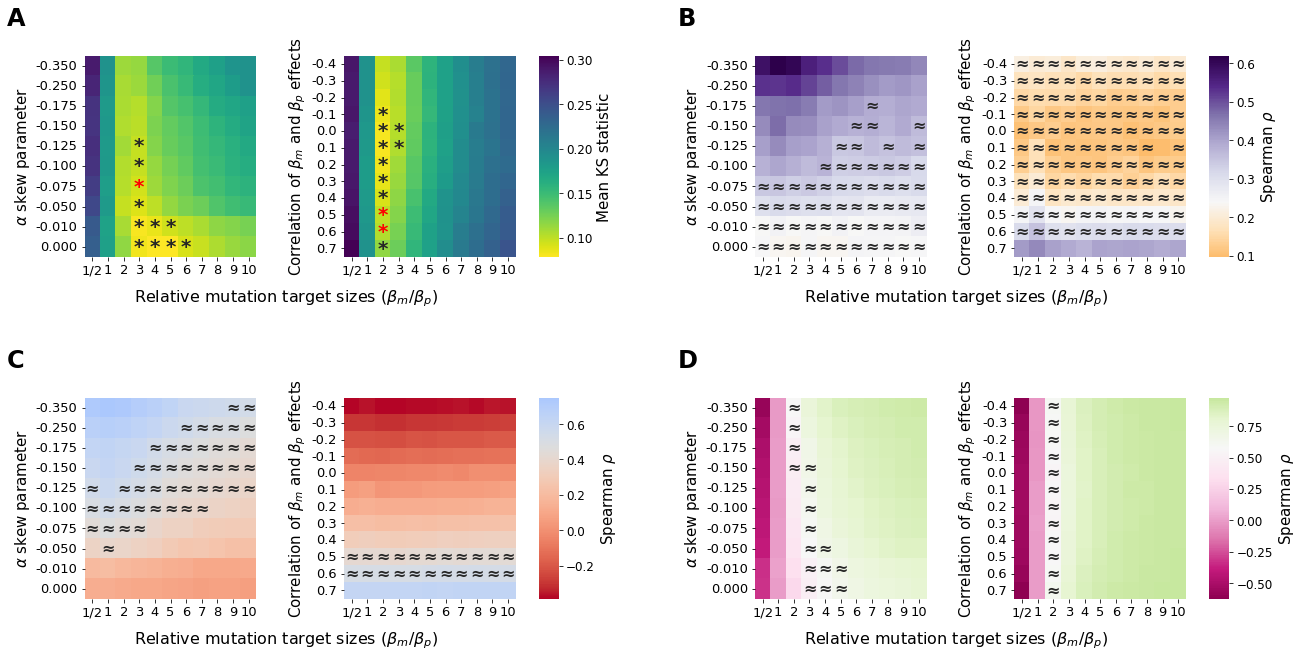

In [36]:
fig = plt.figure(constrained_layout=False, figsize=(18, 10))

# Preparation of the grids
gs1 = fig.add_gridspec(nrows=8, ncols=54, left=0.05, right=0.95, bottom=0.525, 
                       top=0.90, wspace=0.05)
ax1 = fig.add_subplot(gs1[1:7, 1:9])
ax2 = fig.add_subplot(gs1[1:7, 13:21])
ax3 = fig.add_subplot(gs1[1:7, 22:23])

ax4 = fig.add_subplot(gs1[1:7, 32:40])
ax5 = fig.add_subplot(gs1[1:7, 44:52])
ax6 = fig.add_subplot(gs1[1:7, 53:54])

gs2 = fig.add_gridspec(nrows=8, ncols=54, left=0.05, right=0.95, bottom=0.05, 
                       top=0.425, wspace=0.05)

ax7 = fig.add_subplot(gs2[1:7, 1:9])
ax8 = fig.add_subplot(gs2[1:7, 13:21])
ax9 = fig.add_subplot(gs2[1:7, 22:23])

ax10 = fig.add_subplot(gs2[1:7, 32:40])
ax11 = fig.add_subplot(gs2[1:7, 44:52])
ax12 = fig.add_subplot(gs2[1:7, 53:54])

# Minimal and maximal values for each heatmap
min_corr = np.min(np.min([rho_min_all_a.values.min(), rho_min_all_b.values.min()]))
max_corr = np.max(np.max([rho_min_all_a.values.max(), rho_min_all_b.values.max()]))

min_KS = np.min(np.min([KS_means_a.values.min(), KS_means_b.values.min()]))
max_KS = np.max(np.max([KS_means_a.values.max(), KS_means_b.values.max()]))

min_sign = np.min(np.min([rho_sign_all_a.values.min(), rho_sign_all_b.values.min()]))
max_sign = np.max(np.max([rho_sign_all_a.values.max(), rho_sign_all_b.values.max()]))

min_ratio = np.min(np.min([rho_ratio_all_a.values.min(), rho_ratio_all_b.values.min()]))
max_ratio = np.max(np.max([rho_ratio_all_a.values.max(), rho_ratio_all_b.values.max()]))

# Parameter(s) for the heatmaps
annot_params_KS = {"fontsize":20, "fontweight":'bold'}
annot_params_red = {"fontsize":20, "fontweight":'bold', 'c':'red'}

annot_params = {"fontsize":16, "fontweight":'bold'}

# First two heatmaps
heat1 = sns.heatmap(KS_means_a, vmin=min_KS, vmax=max_KS, cmap='viridis_r',
                    ax=ax1, annot=Moods_any_a, fmt = '', 
                    annot_kws=annot_params_KS, cbar=False)

heat1_2 = sns.heatmap(KS_means_a, vmin=min_KS, vmax=max_KS, cmap='viridis_r',
                    ax=ax1, annot=annot_all, fmt = '', 
                    annot_kws=annot_params_red, cbar=False)

heat2 = sns.heatmap(KS_means_b, vmin=min_KS, vmax=max_KS, cmap='viridis_r',
                    ax=ax2, annot=Moods_any_b, fmt = '', 
                    annot_kws=annot_params_KS, cbar_ax=ax3)

heat2_2 = sns.heatmap(KS_means_b, vmin=min_KS, vmax=max_KS, cmap='viridis_r',
                    ax=ax2, annot=annot_all_b, fmt = '', 
                    annot_kws=annot_params_red, cbar=False)

cbar = ax2.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Mean KS statistic', fontsize=15)

# Heatmaps of divergence correlations (magnitude)
heat3 = sns.heatmap(rho_min_all_a, vmin=min_corr, vmax=max_corr, cmap='PuOr', 
                    center=center_div, ax=ax4, annot=rho_equal_a, fmt = '', 
                    annot_kws=annot_params, cbar=False)

heat4 = sns.heatmap(rho_min_all_b, vmin=min_corr, vmax=max_corr, cmap='PuOr', 
                    center=center_div, ax=ax5, annot=rho_equal_b, fmt = '', 
                    annot_kws=annot_params, cbar_ax=ax6)

cbar = ax5.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r"Spearman $\rho$", fontsize=15)

# Heatmaps of signed divergence correlations
heat5 = sns.heatmap(rho_sign_all_a, vmin=min_sign, vmax=max_sign, cmap='coolwarm_r', 
            center=center_sign, ax=ax7, annot=rho_sign_equal_a, fmt = '', 
            annot_kws=annot_params, cbar=False)

heat6 = sns.heatmap(rho_sign_all_b, vmin=min_sign, vmax=max_sign, cmap='coolwarm_r', 
            center=center_sign, ax=ax8, annot=rho_sign_equal_b, fmt = '', 
            annot_kws=annot_params, cbar_ax=ax9)

cbar = ax8.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r"Spearman $\rho$", fontsize=15)

# Heatmaps of divergence ratio correlations

heat7 = sns.heatmap(rho_ratio_all_a, vmin=min_ratio, vmax=max_ratio, cmap='PiYG', 
                    ax=ax10, annot=rho_ratio_equal_a, fmt = '', 
                    center=center_ratio, annot_kws=annot_params, cbar=False)

heat8 = sns.heatmap(rho_ratio_all_b, vmin=min_ratio, vmax=max_ratio, cmap='PiYG', 
                    ax=ax11, annot=rho_ratio_equal_b, fmt = '', 
                    center=center_ratio, annot_kws=annot_params, 
                    cbar_ax=ax12)

cbar = ax11.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r"Spearman $\rho$", fontsize=15)

# Axes labels and annotations
# Manual addition of xlabels
ax1.annotate(r"Relative mutation target sizes ($\beta_m$/$\beta_p$)",
             (0.285, -0.225), xycoords='axes fraction', fontsize=16)
ax4.annotate(r"Relative mutation target sizes ($\beta_m$/$\beta_p$)",
             (0.285, -0.225), xycoords='axes fraction', fontsize=16)
ax7.annotate(r"Relative mutation target sizes ($\beta_m$/$\beta_p$)",
             (0.285, -0.225), xycoords='axes fraction', fontsize=16)
ax10.annotate(r"Relative mutation target sizes ($\beta_m$/$\beta_p$)",
             (0.285, -0.225), xycoords='axes fraction', fontsize=16)

# Addition of ylabels
for ax in [ax1, ax4, ax7, ax10]:
  ax.set_ylabel(r"$\alpha$ skew parameter", fontsize=15)

for ax in [ax2, ax5, ax8, ax11]:
  ax.set_ylabel(r"Correlation of $\beta_m$ and $\beta_p$ effects", fontsize=15)

# Size of all ticks
for ax in [ax1, ax2, ax4, ax5, ax7, ax8, ax10, ax11]:
  ax.tick_params(axis='both', which='major', labelsize=13)

#Annotations of figures
ax1.annotate('A', (-0.45, 1.15), xycoords='axes fraction', fontsize=24, 
             fontweight='bold')
ax4.annotate('B', (-0.45, 1.15), xycoords='axes fraction', fontsize=24, 
             fontweight='bold')
ax7.annotate('C', (-0.45, 1.15), xycoords='axes fraction', fontsize=24, 
             fontweight='bold')
ax10.annotate('D', (-0.45, 1.15), xycoords='axes fraction', fontsize=24, 
             fontweight='bold')

# Saving the figure
Fig5 = plt.gcf()
Fig5.savefig('/content/drive/My Drive/Redaction_SA/Final_figures/'
             'Fig5_final.pdf', bbox_inches='tight')